# Welcome to the AIMS Jupyter Notebook!
# As a refresher, hit ctrl + enter to run each cell
I tried to add comments and other markdown cells like this one where appropriate to help with interpretationsm

In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

# Here is the Notebook Version of the AIMS GUI (MHC Version)
Mostly identical to what is going on inside the app, but you have a little bit more flexibility for customization. This notebook code should be quite flexible, and you really should only have to customize the below cell and then run the rest of the cells as-is.

NOTE FOR UPDATE 08/31/21. I hate not yet updated this MHC section. Will do so soon, but assume most users are interested in the Ig analysis
Please open up an issue ASAP if this section being left behind is an issue. It should still work, just doesn't have all the bells & whistles

In [2]:
# So this is still the primary issue with the MHC code... Need to manually define the bounds of the key MHC structural features
# Would like to automate this process at some point, but haven't found something fast enough yet.
# See the eLife paper (elifesciences.org/articles/61393) for more details how these numbers are determined
x1 = np.array(['cd1','HLA-A','CartFish','UAA','UDA']); x2 = np.array(['124','170','22','2','2'])
x3 = np.array(['167','210','66','49','49']); x4 = np.array(['209','260','105','93','93'])
x5 = np.array(['262','306','158','152','152']);  x6 = np.array(['303','348','199','193','193'])
mat_coords = np.transpose(np.vstack((x1,x2,x3,x4,x5,x6)))
paths = ['app/mhc_testData/cd1_seqs.fasta',
'app/mhc_testData/hlaA_seqs.fasta',
'app/mhc_testData/ji_cartFish.fasta',
'app/mhc_testData/UAA_seqs.fasta',
'app/mhc_testData/UDA_seqs.fasta']

In [3]:
# DEFINE PLOT PARAMETERS:
font = {'family' : 'Arial',
'weight' : 'bold',
'size'   : 16}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

Text(0.5, 0, 'Sequence Position')

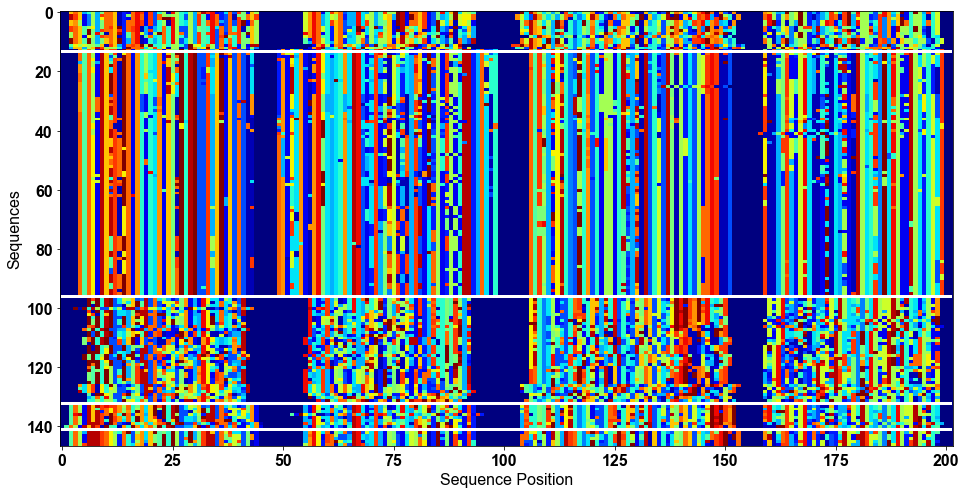

In [4]:
AA_num_key = aims.get_props()[1]
AA_num_key_new = aims.get_props()[2]
labels = mat_coords[:,0]
data = mat_coords[:,1:]
for i in np.arange(len(paths)):
    # turn data into an integer.
    int_dat = [int(x) for x in data[i]]
    seq,seq_key = aimsLoad.mhc_loader(paths[i],int_dat,labels[i])
    if i == 0:
        seq_final = seq
        seq_size = np.shape(seq)[1]
        seqNameF = labels[i]
        seq_keyF = seq_key
        mat_size = aims.get_sequence_dimension(np.array(seq))[0]
    else:
        seq_final = pandas.concat([seq_final,seq],axis = 1)
        seqNameF = np.vstack((seqNameF,labels[i]))
        seq_size = np.vstack((seq_size,np.shape(seq)[1]))
        seq_keyF = np.hstack((seq_keyF,seq_key))
        mat_size2 = aims.get_sequence_dimension(np.array(seq))[0]
        max_lenp=np.zeros(len(mat_size))
        for i in np.arange(len(mat_size)):
            max_lenp[i]=int(max(mat_size[i],mat_size2[i]))
        mat_size = max_lenp       
seq_MI = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
# Convert our MI matrix to a pandas dataframe
seq_MIf = pandas.DataFrame(np.transpose(seq_MI),columns = seq_final.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(seq_MI, interpolation='nearest', aspect='auto',cmap=cm.jet)

seq_locs = 0
for i in np.arange(len(seq_size)-1):
    seq_locs = seq_locs + seq_size[i]
    ax[0,0].plot(np.arange(len(np.transpose(seq_MI))),np.ones(len(np.transpose(seq_MI)))*seq_locs,'white',linewidth = 3)

ax[0,0].set_ylabel('Sequences')
ax[0,0].set_xlabel('Sequence Position')
#fig.savefig('mhc_manuscript_Matrix.pdf',format='pdf',dpi=500)

Text(0, 0.5, 'Normalized Property Value')

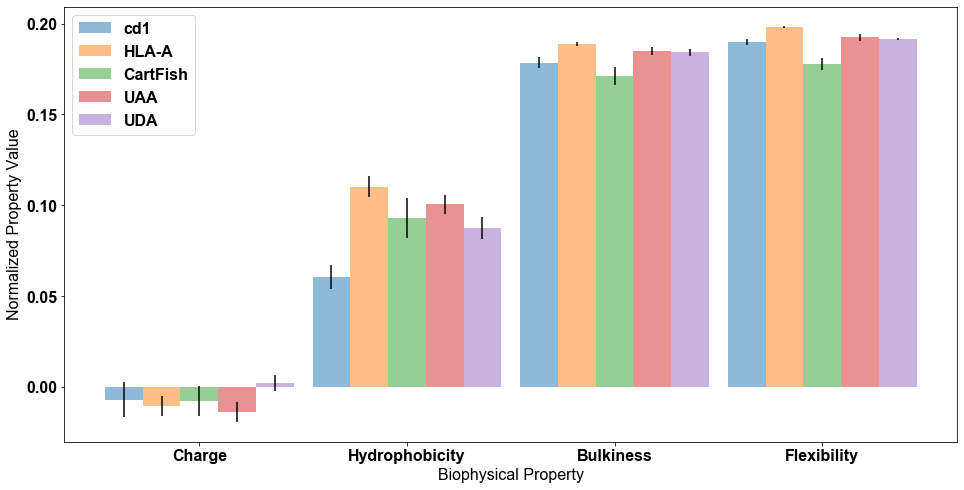

In [5]:
pca_props = aims.gen_clone_props(np.array(np.transpose(seq_MIf)))
pcaF = pandas.DataFrame(pca_props,columns = seq_MIf.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
#colors = ['purple','green','black','orange']
for i in np.arange(len(seqNameF)):
    index = [column for column in pcaF.columns if seqNameF[i][0] in column]
    plotThis = np.array(pcaF[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax[0,0].bar(x_axis+i*1/len(seqNameF), np.average(plotThis[1:5,:],axis = 1),
                yerr = np.std(plotThis[1:5,:],axis = 1),alpha = 0.5, width = 1/len(seqNameF))
ax[0,0].legend(labels)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Bulkiness','Flexibility'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#fig.savefig('mhc_manuscript_properties.pdf',format='pdf',dpi=500)

[0.55420724 0.12545937 0.07130143]


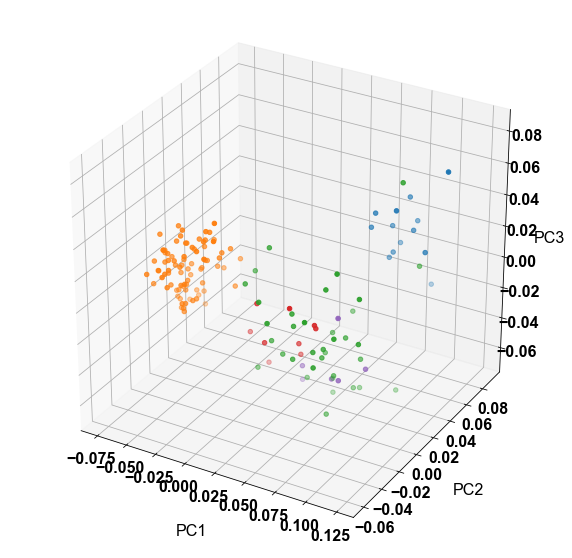

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
final=pca.fit_transform(np.transpose(pca_props))
#seq_PCA = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
#final = pca.fit_transform(seq_PCA)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Alright plot this in an intelligent way
transform_pca = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
for i in np.arange(len(seqNameF)):
    index = [column for column in transform_pca.columns if seqNameF[i][0] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax3d.scatter(plotThis[0], plotThis[1], plotThis[2])

ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
#pl.savefig('PCA_parsedata_3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'PC2')

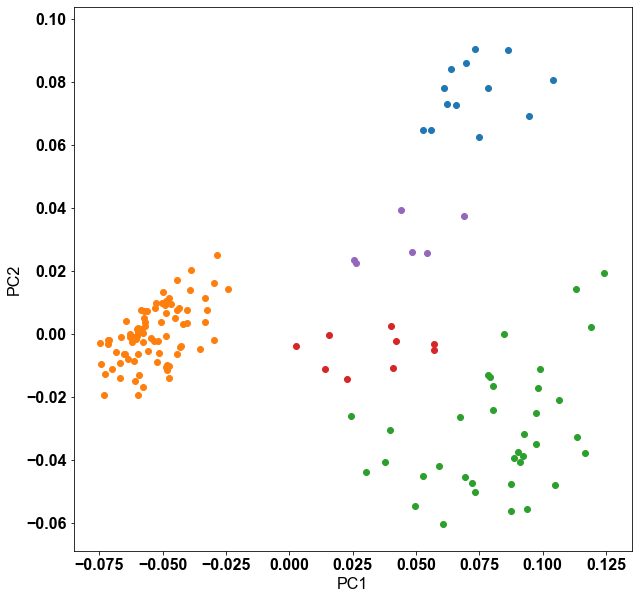

In [7]:
fig = pl.figure(figsize = (10, 10))
for i in np.arange(len(seqNameF)):
    #if i == 2:
    #    continue
    index = [column for column in transform_pca.columns if seqNameF[i][0] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    pl.scatter(plotThis[0], plotThis[1])
    
pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('PCA_2Dparse.pdf',DPI=500,format='pdf')

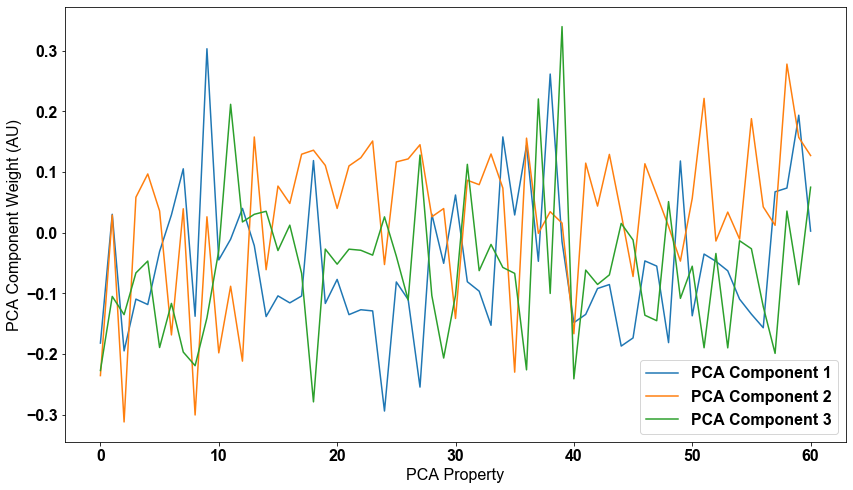

In [8]:
comps1=pca.components_[0]
comps2=pca.components_[1]
comps3=pca.components_[2]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,8))
pl.plot(comps1)
pl.plot(comps2)
pl.plot(comps3)
pl.xlabel('PCA Property')
pl.ylabel('PCA Component Weight (AU)')
pl.legend(['PCA Component 1','PCA Component 2','PCA Component 3'])

Text(0, 0.5, 'Normalized Hydrophobicity')

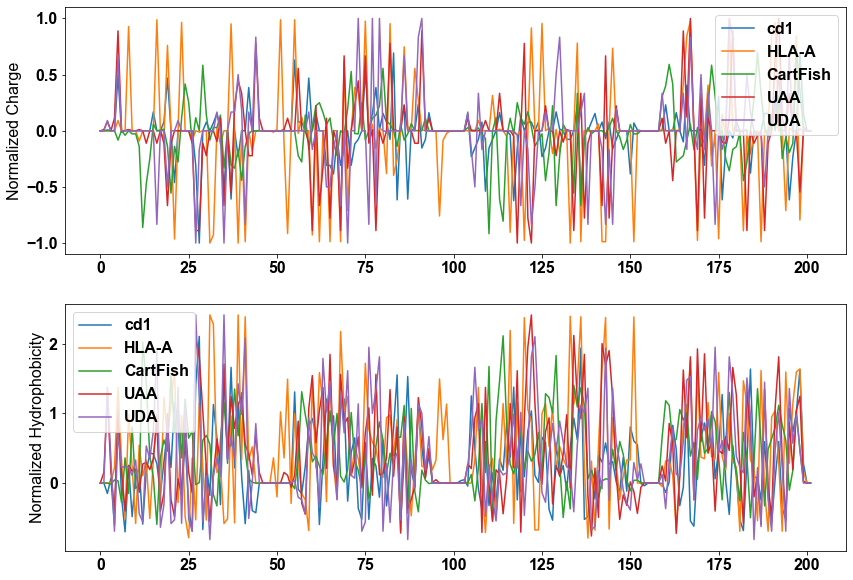

In [9]:
#pos_sens=aims.gen_dset_props(np.array(np.transpose(seq_MIf)),stdev=False)
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
for i in np.arange(len(labels)):
    index = [column for column in seq_MIf.columns if labels[i] in column]
    subset = np.array(seq_MIf[index])
   
    pos_sens=aims.gen_dset_props(np.array(np.transpose(subset)),stdev=False)
    
    for prop in np.arange(2):
        if prop == 0:
            x = 0; y = 0
        elif prop == 1:
            x = 1; y = 0
#        elif prop == 2:
#            x = 1; y = 0
#        elif prop == 3:
#            x = 1; y = 1
        plotThis = pos_sens[prop+2]
        # Specifically plot the first 5 properties here... Make sure that I 
        # have some way soon to actually select these...
        ax[x,y].plot(np.arange(len(plotThis)), plotThis)
ax[0,0].legend(labels)
ax[1,0].legend(labels)

#ax[0,0].set_xticks(xtick_loc)
#ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

#ax[1,0].set_xticks(xtick_loc)
#ax[1,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')

1.0


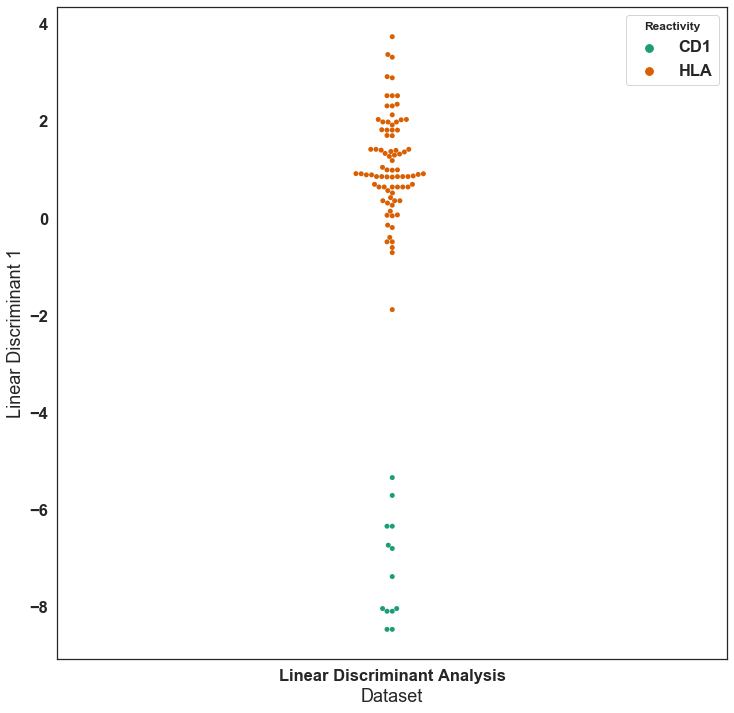

In [10]:
numVects = 10
# Here we also need to get a pre-defined matrix size...
import aims_classification as classy

# Need to split this data into two classes
# We (in the tutorials) have these labels:
#['cd1', 'HLA-A', 'UFA', 'UAA', 'UDA']
# So let's split these up into the below classes:
class_assign = [1,2,0,0,0]
# Here we have 1 = class 1, 2 = class 2, and we'll keep 0 as "unassigned"

class0 = []
class1 = []
class2 = []
for i in np.arange(len(labels)):
    index = [column for column in seq_final.columns if labels[i] in column]
    subset = seq_final[index]
   
    if class_assign[i] == 0:
        if len(class0) == 0:
            class0 = subset
        else:
            class0 = np.hstack((class0,subset))
    elif class_assign[i] == 1:
        if len(class1) == 0:
            class1 = subset
        else:
            class1 = np.hstack((class1,subset))
    elif class_assign[i] == 2:
        if len(class2) == 0:
            class2 = subset
        else:
            class2 = np.hstack((class2,subset))

pg1 = class1.values
pg2 = class2.values

num1 = np.shape(pg1)[1]
num2 = np.shape(pg2)[1]
#pg2 = seq2.values
x,y,MatrixSize = aims.gen_tcr_matrix(pg1,pre_mono=pg2,binary=True,return_Size=True)
full_big, weights, acc_all, mda_all, parsed_mat,top_names = classy.do_linear_split(pg1, pg2, giveSize = MatrixSize, ridCorr = True, matSize = numVects)
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(num1+num2)]
reacts = ["CD1" for x in range(num1)] + ["HLA" for x in range(num2)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
print(acc_all)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")

# So the Above Section DOES Work, but Unfortunately the LDA is Honing in on the Alignment Mismatches
This isn't an issue in the PCA, because it's unbiased. This is where that software to autodefine helices and strands would help a LOT